# Try tesseract OCR

There are following four steps for the basic procedure to recognize the text in the image.

1. Get and resize the image
1. Remove the background noise from the image
1. Recognize the text
1. Correct the possible misreading characters

I am going to introduce all above steps one by one but I do not mention the step 4 very much since it heavily depends on your business. For instance, the text format that you want to recognize have 2-character upper case alphabet and 8-digit numeric like ``AB12345678``. In this case, you can replace "l" (lower L) to "I" (upper i) in the alphabet region but you should replace it to "1" (numeric one) if you found the character in the numeric region. So, I would like to introduce very simple code to pick up upper case alphabet and numeric only in this sample.

## Preparation

### Import libraries

Let's import the following libraries.

In [1]:
import pyocr
import pyocr.builders
import numpy as np
import cv2
import re
from PIL import Image, ImageDraw
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN
import matplotlib.pyplot as plt
%matplotlib inline

###  Compute the similarity of the two images

This function returns the similarity between two images by using the difference of the histgram. It may be hard to find the difference between two images if you only look at the images by your eyes. So, I use the similarity to figure out how much the images are different.

In [2]:
def get_similarity(img1, img2):
    hist1 = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
    result = cv2.compareHist(hist1, hist2, 0)
    return result

### Parameters

These parameters are key to remove the background noise. You need to set the appropriate value to get the clear image. Many many try and error are required. You can try the value that returns both accurate and wrong text.

In [3]:
resize_to = (400, 80)     # Rescale the image more than 300 dpi
block_size = 147           # Block size for adaptive thresholding. This should be positive and odd value more than 1. 
C = 31                          # The constant to subtract from mean or weighted mean
threshold = 140            # The threshold for simple thresholding
open_ksize = (5, 5)       # The kernel size to remove white patch in black region
close_ksize = (3, 3)      # The kernel size to remove black patch in white region
blur_ksize = (5, 5)        # The Gaussian kernel size to set blur. This should be positive and odd value

### Load the grayscale image

Load the grayscale image that is already synthesized.

image shape (20, 100)


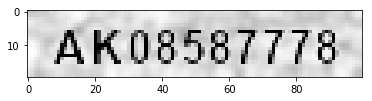

In [4]:
img_generated = cv2.imread('../dataset/sample/AK08587778.png', cv2.IMREAD_GRAYSCALE)
print('image shape', img_generated.shape)
cv2.imwrite('../doc_resources/grayscale_image.png', img_generated)
plt.gray()
plt.imshow(img_generated)

### Resize image

tesseract OCR engine needs 300 dpi image but the synthesized image is 72 dpi. I need to enlarge the image at least 4 times wider in x and y axis since it is too small and low resolution. I resize the image to 4 times larger than original one at this time.

resize to (80, 400)
similarity: 0.8735521030773739


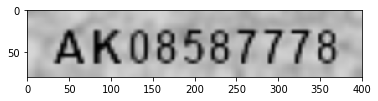

In [5]:
img_resized = cv2.resize(img_generated, resize_to, interpolation = cv2.INTER_LINEAR)
print('resize to', img_resized.shape)
print('similarity:', get_similarity(img_generated, img_resized))
cv2.imwrite('../doc_resources/resized_image.png', img_resized)
plt.imshow(Image.fromarray(img_resized))

## Remove background noise

Let's remove the background noise while binarizing the grayscale image. There are several methods to get the binary image from the grayscale image. However, I create two binary images using adaptive threshold and simple threshold, and then I conbine the both images by bit-wise OR method to make sure the white region as white. (white is 0xFF and it means all bits are ON)

### Get binary image with adaptive threshold

#### Adaptive threshold

The adaptive threshold method give us different thresholds for different regions of the same image and it gives us better results for images with varying illumination.

Refer to [Image Thresholding : OpenCV-Python Tutrials](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

similarity: -0.04252420091227238


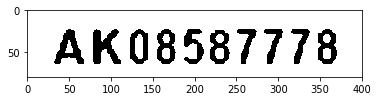

In [6]:
img_adaptive = cv2.adaptiveThreshold(img_resized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, C)
print('similarity:', get_similarity(img_resized, img_adaptive))
cv2.imwrite('../doc_resources/adaptive_image.png', img_adaptive)
plt.imshow(img_adaptive)

#### Remove white noise in black region

Firstly I remove the white blocks in the black region from the binary image that is created by adaptive threashold. The block size is defined as kernel size of opening.

Refer to the [Morphological Transformations : OpenCV-Python Tutrials](https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html)

similarity: 0.9999880218901825


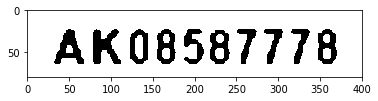

In [7]:
img_morph_open = cv2.morphologyEx(img_adaptive, cv2.MORPH_OPEN, np.ones(open_ksize, np.uint8))
print('similarity:', get_similarity(img_morph_open, img_adaptive))
cv2.imwrite('../doc_resources/morph_open_image.png', img_morph_open)
plt.imshow(img_morph_open)

#### Remove black noise in white resion

Secondly I remove the black blocks in the white region form the binary image that the white noise is removed. The block size is defined as kernel size of closing.

Refer to the [Morphological Transformations : OpenCV-Python Tutrials](https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html)

similarity: 0.9999998117816038


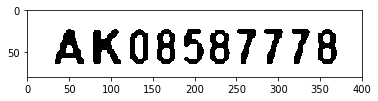

In [8]:
img_morph_close = cv2.morphologyEx(img_morph_open, cv2.MORPH_CLOSE, np.ones(close_ksize, np.uint8))
print('similarity:', get_similarity(img_morph_open, img_morph_close))
cv2.imwrite('../doc_resources/morph_close_image.png', img_morph_close)
plt.imshow(img_morph_close)

### Get binary image with simple threshold

#### Simple threshold

We use a global value as threshold value. This means I binarize the image only one global value instead of using differenct value for different regions of the image like adaptive threshold. 

 Refer to [Simple Thresholding : OpenCV-Python Tutrials](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

similarity: -0.04302254591157132


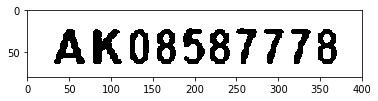

In [9]:
result, img_threshold = cv2.threshold(img_resized, threshold, 255, cv2.THRESH_BINARY)
print('similarity:', get_similarity(img_threshold, img_resized))
cv2.imwrite('../doc_resources/simple_threshold_image.png', img_threshold)
plt.imshow(img_threshold)

#### OTSU's binarization

OTSU's binarization automatically calculates a threshold value from image histogram for a bimodal image. So I do not need to set any threshold value.

 Refer to [OTSU's Binarization : OpenCV-Python Tutrials](https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html)

similarity: 0.9995666975138376


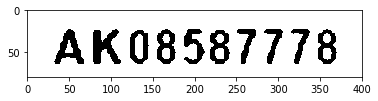

In [10]:
result, img_OTSU = cv2.threshold(img_resized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print('similarity:', get_similarity(img_OTSU, img_threshold))
cv2.imwrite('../doc_resources/OTSU1_image.png', img_OTSU)
plt.imshow(img_OTSU)

#### Smoothing with gaussian blur

Blur is useful for removing noises. It actually removes high frequency content (eg: noise, edges) from the image.

Refer to [Image Blurring (Image Smoothing) : OpenCV-Python Tutrials](https://docs.opencv.org/3.4/d4/d13/tutorial_py_filtering.html)

similarity: 0.9895459819028379


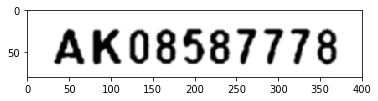

In [11]:
img_blur = cv2.GaussianBlur(img_OTSU, blur_ksize, cv2.BORDER_CONSTANT)
print('similarity:', get_similarity(img_OTSU, img_blur))
cv2.imwrite('../doc_resources/Blur_image.png', img_blur)
plt.imshow(img_blur)

#### OTSU's threshold again

We use OTSU's binarization again.

similarity: 0.9888212847226167


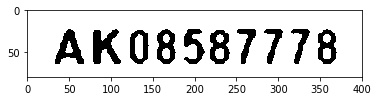

In [12]:
result, img_OTSU2 = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print('similarity:', get_similarity(img_OTSU2, img_blur))
cv2.imwrite('../doc_resources/OTSU2_image.png', img_OTSU2)
plt.imshow(img_OTSU2)

### Make sure white region

Calculates the per-element bit-wise disjunction of two arrays. This means set the dot as white if either adaptive threshold based image or simple threshold based image say the dot is white.

similarity(to OTSU2): 0.9999935428445347
similarity(to Morph): 0.9999436731322505


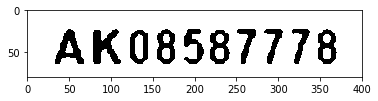

In [13]:
img_bitwise = cv2.bitwise_or(img_OTSU2, img_morph_close)
print('similarity(to OTSU2):', get_similarity(img_OTSU2, img_bitwise))
print('similarity(to Morph):', get_similarity(img_morph_close, img_bitwise))
cv2.imwrite('../doc_resources/bitwiseOr.png', img_bitwise)
plt.imshow(img_bitwise)

# Recognize text

OCR engine might misread that the image contains the characters except alpha-numeric if you set the parameter to inappropriate value. You will find the rectangle of the characters draws wider area than the area when you set the parameter to appropriate value.

Refer to [Page segmentation method](https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality#page-segmentation-method) to understand what velue should we set to "tesseract_layout". We set the value to 6 this time since we are recognizing 10-character block as a text. I think 6 and 7 will give you better result in this uniformed 10-character textt.

num of line: 1
content: AK08587778
num of word box: 1
confidence: 87
position: ((33, 23), (370, 65))


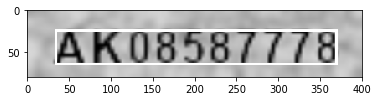

In [17]:
tools = pyocr.get_available_tools()
tool = tools[0]

# Recognize the text.
lines = tool.image_to_string(Image.fromarray(img_bitwise), lang='eng', builder=pyocr.builders.LineBoxBuilder(tesseract_layout=7))
print('num of line:', len(lines))
print('content:', lines[0].content)
print('num of word box:', len(lines[0].word_boxes))
print('confidence:', lines[0].word_boxes[0].confidence)
print('position:', lines[0].position)

# Show the rectangle around the text.
img_rectangle = Image.fromarray(img_resized)
draw = ImageDraw.Draw(img_rectangle)
draw.rectangle(lines[0].position, outline=255, width=3)
img_rectangle.save('../doc_resources/rectangle.png')
plt.imshow(img_rectangle)

# Correct possible misreading characters

I sinply remove the characters that are not upper case alphabet or numeric to correct the recognition result. I can get the accurate text even though OCR engine returns wrong text in this case.

In [15]:
# Very simple replacement for the misreading characters. Remove characters except uppercase alphabet and numeric.
m = re.findall("[A-Z0-9]", lines[0].content)
if m:
    print(''.join(m))
else:
    print('None')

AK08587778
